## Galveston Testbed Notebook

### 1 Background:
Galveston Island is a barrier island located southeast of Houston, TX. The region has been repeatedly impacted by coastal storms and flood hazards, and has a population that is racially and ethnically diverse, with a wide income distribution. This testbed was created to provide an opportunity to: 

a) Investigate the multi-hazard surge, wave, inundation, and wind hazards in coastal settings.

b) Consider interdependent infrastructure systems including buildings, transportation, and power.

c) Leverage historical social-science data, informing population dislocation and recovery modeling. 

d) Evaluate hybrid metrics of community resilience, such as those that require coupled modeling between social and physical systems.

![Galveston](images/Galveston.png)


The current notebook is a **WORK-IN-PROGRESS** that consists of the following modules:

a)	Flood Surge, Wave, and Inundation Models 

b)	Galveston Building Damage Analysis 

c)	Galveston Household Unit Allocation

d)	Galveston Population Dislocation Model based on Hurricane IKE

Other modules such as road and bridge damage analysis, power system analysis, and network analysis to investigate the connectivity of building clusters to emergency services and power will be added to the Notebook in the near future, as associated models are deployed in INCORE.

### Prerequisites

The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through **conda**.

| Module | Version | Notes |
| --- | --- | --- |
| pyIncore | =>0.9.3 | see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html |
| pyIncore_viz | =>1.1.0 | see: https://incore.ncsa.illinois.edu/doc/pyincore_viz/index.html |

### 2 Flood Surge, Wave, and Inundation Models:

Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2%, 1%, and 0.2% Annual Exceedance Probabilities (AEP) were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. The hindcast simulation was performed using a high-resolution unstructured mesh of the Texas coast, with coverage of the entire Gulf of Mexico basin, having more than 3.3 million nodes and 6.6 million mesh elements. The data are available in terms of 100-m rasterized files with the following IDs in INCORE:

- Hurricane Ike Hindcast: ID: `5fa5a228b6429615aeea4410`

- 2% Annual Exceedance Probability (50-yr return period): ID: `5fa5a83c7e5cdf51ebf1adae`

- 1% Annual Exceedance Probability (100-yr return period): ID: `5fa5a9497e5cdf51ebf1add2`

- 0.2% Annual Exceedance Probability  (500-yr return period): ID: `5fa5aa19b6429615aeea4476`

There is also a hazard scenario generated based on historical data with the following ID: `5f15cd627db08c2ccc4e3bab`


### 3 Galveston Building Damage

The following code is preparing the IN-CORE analysis by checking versions and connecting to IN-CORE web service.

In [1]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService, FragilityCurveSet, FragilityService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz
from pyincore_viz.plotutil import PlotUtil as plot

In [2]:
# Check package versions - good practice for replication
print("Python Version ",sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.7.7 (tags/v3.7.7:d7c567b08f, Mar 10 2020, 10:41:24) [MSC v.1900 64 bit (AMD64)]
pandas version:  1.0.5
numpy version:  1.19.0


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'C:\\Workspace-incore2\\incore-docs\\manual\\source\\notebooks\\Galveston_testbed'

In [4]:
client = IncoreClient()

Connection successful to IN-CORE services. pyIncore version detected: 0.9.0


#### 3.1 Building Inventory

The building inventory for Galveston consists of 18,962 individual residential households. This inventory is also mappable to housing unit info of 32,501 individual households explained later in this notebook. It should be noted that the reason that the building and household data are different in terms of numbers is that each individual building can be composed of a few households. The building inventory consists of three major parameters that are used to estimate the fragility of buildings explained shortly later in this notebook. The three parameters are: 

a) Elevation of the lowest horizontal structural member

b) Age group of the building (1, 2, 3, and 4 representing age group pre-1974, 1974–1987, 1987–1995, and 1995– 2008, respectively) 

c) Elevation of the building with respect to the ground


#### 3.2 Building Fragility

The fragility model used to estimate failure probability during storm surge events is extracted from:

>Tomiczek, T. Kennedy, A, and Rogers, S., 2013. Collapse limit state fragilities of wood-framed residences from storm surge and waves during Hurricane Ike. Journal of Waterway, Port, Coastal, and Ocean Engineering, 140(1), pp.43-55.

This empirical fragility model was developed based on Hurricane Ike surveys of almost 2000 individual wood-frame buildings coupled with high resolution hindcast of the hurricane. For this study two states of damage, “Collapse” and “Survival” were considered.
________________________________________
The input parameters to the fragility model are:

1) Surge: surge level (m) coming from hazard data

2) Hs: Significant wave height (m) coming from hazard data

3) LHSM: Elevation of the lowest horizontal structural member (ft) coming from building inventory

4) age_group: Age group of the building (1, 2,3, and 4 representing age group pre-1974, 1974–1987, 1987–1995, and 1995– 2008, respectively) coming from building Inventory

5) G_elev: Elevation of the building with respect to the ground (m) coming from building inventory
________________________________________
Output:
Pf: probability of failure
________________________________________
In order to calculate the probability of failure, first we need to estimate the relative surge height compared to the ground level from:
𝑑𝑠=𝑆𝑢𝑟𝑔𝑒−𝐺𝑒𝑙𝑒𝑣ds

Subsequently, we need to calculate the following parameter

𝐹𝐵ℎ𝑠=−(𝑑𝑠+0.7∗𝐻𝑠−𝐿𝐻𝑆𝑀∗0.3048)
Note: 0.3048 is to convert ft to m as the inventory data are in ft.

Then:

For FB_hs>= -2.79*Hs the probability of failure is calculated as:
𝑃𝑓=Φ(−3.56+1.52∗𝐻𝑠−1.73∗𝐻𝑠∗𝐹𝐵ℎ𝑠−0.31∗𝐹𝐵2ℎ𝑠−0.141∗𝑎𝑔𝑒2𝑔𝑟𝑜𝑢𝑝)

and for FB_hs< -2.79*Hs
𝑃𝑓=Φ(−3.56+1.52∗𝐻𝑠+2.42∗𝐹𝐵2ℎ𝑠−0.141∗𝑎𝑔𝑒2𝑔𝑟𝑜𝑢𝑝)
Where Φ denotes the Cumulative Density Function (CDF) of standard normal distribution.
________________________________________
Example:
If Surge=3 m, Hs =2 m, LHSM=9 ft, age_group=4; G_elev =1 m
Then Pf= 0.2620


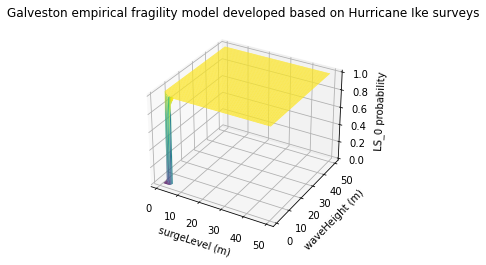

In [5]:
# use utility method of pyicore-viz package to visulaize the fragility
fragility_set = FragilityCurveSet(FragilityService(client).get_dfr3_set("5f6ccf67de7b566bb71b202d"))
plt = plot.get_fragility_plot_3d_refactored(fragility_set, 
                                            title="Galveston empirical fragility model developed "
                                            "based on Hurricane Ike surveys",
                                            limit_state="LS_0")
plt.show()

The following code sets up a buidling damage analysis with input datasets and parameters, then runs the analysis

In [6]:
hazard_type = "hurricane"
# Galveston deterministic Hurricane, 3 datasets - Kriging
hazard_id = "5fa5a228b6429615aeea4410"
# visualization
wave_height_id = "5f15cd62c98cf43417c10a3f"
surge_level_id = "5f15cd5ec98cf43417c10a3b"

# Galveston, TX Building inventory
bldg_inv_id = "60354b6c123b4036e6837ef7" # 19k buildings with age_group

# Hurricane building mapping (with equation)
mapping_id = "602c381a1d85547cdc9f0675"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [7]:
# visualize wave height
dataset = Dataset.from_data_service(wave_height_id, DataService(client))
map = viz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [8]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

In [9]:
# visualize surge level
dataset = Dataset.from_data_service(surge_level_id, DataService(client))
map = viz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [10]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

Box(children=(FloatSlider(value=1.0, description='opacity', max=1.0, step=0.01),))

In [11]:
bldg_dmg = BuildingDamage(client)

bldg_dmg.load_remote_input_dataset("buildings", bldg_inv_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [12]:
result_name = "Galveston_bldg_dmg_result"

bldg_dmg.set_parameter("fragility_key", "Hurricane SurgeLevel and WaveHeight Fragility ID Code")
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)

True

In [13]:
bldg_dmg.run_analysis()

True

#### 3.3 Explore Building Damage Results

In [14]:
# Retrieve result dataset
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

In [15]:
# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df.head()

,guid,LS_0,LS_1,LS_2,DS_0,DS_1,DS_2,DS_3
0,b39dd67f-802e-402b-b7d5-51c4bbed3464,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,e7467617-6844-437e-a938-7300418facb8,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,d7ce12df-660d-42fc-9786-f0f543c00002,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,74aac543-8aae-4779-addf-754e307a772b,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,ed3147d3-b7b8-49da-96a9-ddedfccae60c,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
bdmg_df.DS_0.describe()

count    18962.000000
mean         0.882955
std          0.309319
min          0.000000
25%          0.999420
50%          1.000000
75%          1.000000
max          1.000000
Name: DS_0, dtype: float64

In [17]:
bdmg_df.DS_3.describe()

count    18962.000000
mean         0.117045
std          0.309319
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000580
max          1.000000
Name: DS_3, dtype: float64

Based on hazard and damage analsyis 87% of structures would survive damage and 13% would have collapse from damage.

### 4 Galveston Housing Unit Allocation (HUA)

Housing Unit Allocation using Galveston, Texas Housing Unit Inventory

Here we link high-resolution spatial data on 32501 individual household and housing unit characteristics to residential buildings. Critical for linking socio-economic data within IN-CORE. For evacuation example HUA is required to identify the people that may not evacuate after event.
The models come from: 

>Rosenheim, Nathanael, Roberto Guidotti, Paolo Gardoni & Walter Gillis Peacock. (2019). Integration of detailed household and housing unit characteristic data with critical infrastructure for post-hazard resilience modeling. Sustainable and Resilient Infrastructure. doi.org/10.1080/23789689.2019.1681821


In [18]:
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

#### 4.1 Initial Interdependent Community Description - Galveston, Texas

Explore building inventory and social systems. Specifically look at how the building inventory connects with the housing unit inventory using the housing unit allocation.
The housing unit allocation method will provide detail demographic characteristics for the community allocated to each structure.

To run the HUA Algorithm, three input datasets are required:

1. Housing Unit Inventory - Based on 2010 US Census Block Level Data

2. Address Point Inventory - A list of all possible residential/business address points in a community. Address points are the link between buildings and housing units.

3. Building Inventory - A list of all buildings within a community.


In [19]:
# Galveston, TX Housing unit inventory
housing_unit_inv = "5fc6ab1cd2066956f49e7a03"
# Galveston, TX Address point inventory
address_point_inv = "5fc6aadcc38a0722f563392e"
# Galveston, TX Building inventory
building_inv = "60354b6c123b4036e6837ef7"

#### 4.2 Set Up and Run Housing Unit Allocation

In [20]:
# Create housing allocation 
hua = HousingUnitAllocation(client)

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv)
hua.load_remote_input_dataset("buildings", building_inv)

# Specify the result name
result_name = "Galveston_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [21]:
# Run Housing unit allocation analysis
hua.run_analysis()

True

#### 4.3 Explore results from Housing Unit Allocation

Keep observations that are matched to a building.

In [22]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df[['guid','numprec','incomegroup']].head()

,guid,numprec,incomegroup
0,eca98323-d57f-4691-a340-b4e0e19c2346,2,15.0
1,eca98323-d57f-4691-a340-b4e0e19c2346,2,17.0
2,eca98323-d57f-4691-a340-b4e0e19c2346,1,17.0
3,eca98323-d57f-4691-a340-b4e0e19c2346,2,17.0
4,eca98323-d57f-4691-a340-b4e0e19c2346,2,17.0


In [23]:
hua_df.columns

Index(['addrptid', 'strctid', 'archetype', 'struct_typ', 'year_built',
       'no_stories', 'a_stories', 'b_stories', 'bsmt_type', 'sq_foot',
       'gsq_foot', 'occ_type', 'occ_detail', 'major_occ', 'broad_occ',
       'appr_bldg', 'repl_cst', 'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl',
       'cont_val', 'efacility', 'dwell_unit', 'str_typ2', 'occ_typ2',
       'appr_land', 'appr_tot', 'guid', 'ffe_elev', 'age_group', 'lhsm_elev',
       'g_elev', 'blockid', 'blockidstr', 'huestimate', 'residential',
       'bldgobs', 'yrblt', 'aprbldg', 'x', 'y', 'parid', 'randomap',
       'randommergeorder', 'huid', 'tractid', 'bgid', 'FIPScounty', 'serialno',
       'livetype', 'numprec', 'gqpop', 'ownershp', 'race', 'hispan',
       'hispan_flag', 'vacancy', 'gqtype', 'incomegroup', 'randincome',
       'randomhu', 'aphumerge', 'geometry'],
      dtype='object')

##### To help explore data create a new variable that combines race and ethnicity.

In [24]:
def add_race_ethnicity_to_df(df):
   
    df = df.loc[df['aphumerge'] == 'both']
    
    df['Race Ethnicity'] = "0 Vacant HU No Race Ethnicity Data"
    df['Race Ethnicity'].notes = "Identify Race and Ethnicity Housing Unit Characteristics."

    df.loc[(df['race'] == 1) & (df['hispan'] == 0),'Race Ethnicity'] = "1 White alone, Not Hispanic"
    df.loc[(df['race'] == 2) & (df['hispan'] == 0),'Race Ethnicity'] = "2 Black alone, Not Hispanic"
    df.loc[(df['race'].isin([3,4,5,6,7])) & (df['hispan'] == 0),'Race Ethnicity'] = "3 Other Race, Not Hispanic"
    df.loc[(df['hispan'] == 1),'Race Ethnicity'] = "4 Any Race, Hispanic"
    df.loc[(df['gqtype'] >= 1),'Race Ethnicity'] = "5 Group Quarters no Race Ethnicity Data"
    
    return df

In [25]:
hua_df = add_race_ethnicity_to_df(hua_df)

In [26]:
table_title = "Table 1. Total Population by Race and Ethnicity"
table1 = pd.pivot_table(hua_df, values='numprec', index='Race Ethnicity', aggfunc=np.sum)
table1.style.set_caption(table_title)

,numprec
Race Ethnicity,
0 Vacant HU No Race Ethnicity Data,0
"1 White alone, Not Hispanic",21220
"2 Black alone, Not Hispanic",8302
"3 Other Race, Not Hispanic",1698
"4 Any Race, Hispanic",13424
5 Group Quarters no Race Ethnicity Data,240


#### 4.4 Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

https://data.census.gov/cedsci/table?q=DECENNIALPL2010.P5&g=1600000US4828068,4837252&tid=DECENNIALSF12010.P5
    
Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building dresults will become the input for the dislocation model.

In [27]:
# Save cleaned HUA file as CSV
hua_df.to_csv(result_name + str(seed) + '_cleaned.csv')

#### 4.5 Visualize heat map

In [28]:
map = viz.plot_heatmap_from_gdf(hua_df, "numprec", radius=7, blur=10, name="HUA Heatmap")
map

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

### 5 Galveston Population Dislocation
Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

#### 5.1 Set Up and Run Population Dislocation 

In [29]:
from pyincore.analyses.populationdislocation import PopulationDislocation

In [30]:
# Galveston, TX Block group data, IN-CORE_BGMAP_2021-01-19_GalvestonTX
bg_data = "603545f2dcda03378087e708"
# Value loss parameters DS 0-3
value_loss = "60354810e379f22e16560dbd"

In [31]:
pop_dis = PopulationDislocation(client)

In [32]:
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_poss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)
pop_dis.set_input_dataset("housing_unit_allocation", hua_result)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


True

In [33]:
result_name = "galveston-pop-disl-results"
seed = 1111

In [34]:
pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

True

In [35]:
pop_dis.run_analysis()

True

#### 5.2 Explore Population Dislocation Results

In [36]:
# Retrieve result dataset
result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pd_df = result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
pd_df.head()

,guid,DS_0,DS_1,DS_2,DS_3,addrptid,strctid,archetype,struct_typ,year_built,...,Survey,pblackbg,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated
0,b39dd67f-802e-402b-b7d5-51c4bbed3464,1.0,0.0,0.0,0.0,XREF6671-0000-0081-000AP001,XREF6671-0000-0081-000,NaN,W1,NaN,...,2010 dec/sf1,0.839161,7.692308,0,0.002914,0.100425,0.524702,0.889881,0.0,False
1,e7467617-6844-437e-a938-7300418facb8,1.0,0.0,0.0,0.0,XREF6671-0000-0080-000AP001,XREF6671-0000-0080-000,NaN,W1,NaN,...,2010 dec/sf1,0.839161,7.692308,0,0.006930,0.132025,0.677548,0.951019,0.0,False
2,d7ce12df-660d-42fc-9786-f0f543c00002,1.0,0.0,0.0,0.0,XREF6671-0000-0078-000AP001,XREF6671-0000-0078-000,NaN,W1,NaN,...,2010 dec/sf1,0.839161,7.692308,0,0.005776,0.100000,0.654935,0.941974,0.0,False
3,74aac543-8aae-4779-addf-754e307a772b,1.0,0.0,0.0,0.0,XREF6671-0000-0077-000AP001,XREF6671-0000-0077-000,NaN,W1,NaN,...,2010 dec/sf1,0.839161,7.692308,0,0.002404,0.105851,0.436479,0.854591,0.0,False
4,ed3147d3-b7b8-49da-96a9-ddedfccae60c,1.0,0.0,0.0,0.0,XREF6671-0000-0074-000AP001,XREF6671-0000-0074-000,NaN,W1,NaN,...,2010 dec/sf1,0.839161,7.692308,0,0.003029,0.133077,0.438777,0.855511,0.0,False


In [37]:
# To help explore data create a new variable that combines race and ethnicity.
pd_df = add_race_ethnicity_to_df(pd_df)

# Save cleaned Pop Dislocation file as CSV
pd_df.to_csv(result_name + str(seed) + '_cleaned.csv')

In [38]:
popdisresultstables = pd.pivot_table(pd_df, values='numprec', index=['Race Ethnicity'],
                                     margins = True, margins_name = 'Total',
                                     columns=['dislocated'], aggfunc=[np.sum]).rename(
    columns={'sum': 'Total Population',
             False: 'Does not dislocate',
             True: 'Dislocates'})
# add percent dislocated to table
numerator = popdisresultstables[('Total Population','Dislocates')]
denomenator = popdisresultstables[('Total Population','Total')]
popdisresultstables[('Total Population','Percent Dislocation')] = numerator/denomenator * 100

In [39]:
table_title = "Table 1. Population Dislocation for Galveston"
popdisresultstables.style.set_caption(table_title)